<a href="https://www.kaggle.com/code/jonbown/u-s-weekend-box-office-report?scriptVersionId=131638184" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from datetime import date
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import plotly.express as px
from PIL import Image
import requests
from io import BytesIO
import cv2
import string
from IPython.display import Markdown as md
from plotly.offline import init_notebook_mode, iplot, plot

In [2]:
my_date = date.today()
year, week_num, day_of_week = my_date.isocalendar()
if week_num == 1:
    year = year - 1
    week_num = 52
else:
    week_num = week_num - 1
#display(md(f"# **Weekend Box Office Report: {year}, Week {week_num}**"))
display(md(f"<h1 style='background:#f3ce13;border:0; color:black;box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);transform: rotateX(10deg);'><center style='color: black;'>Weekend Box Office Report: {year}, Week {week_num}</center></h1>"))

<h1 style='background:#f3ce13;border:0; color:black;box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);transform: rotateX(10deg);'><center style='color: black;'>Weekend Box Office Report: 2023, Week 21</center></h1>

<div align="center">
<img src="https://ktla.com/wp-content/uploads/sites/4/2022/09/movie-theater-popcorn.jpg"/, width=500>
</div>

> Welcome to the latest edition of the **Weekend Box Office Report**. This report breaks down what happened over the most recent weekend at the box office and who were the biggest winners and losers!

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Data Constrution</center></h1>

In [3]:
#Build URL
if week_num < 10:   
    weekend_url = f'https://www.boxofficemojo.com/weekend/{year}W0{week_num}/?ref_=bo_wey_table_1'
else:
    weekend_url = f'https://www.boxofficemojo.com/weekend/{year}W{week_num}/?ref_=bo_wey_table_1'

In [4]:
#request
req=requests.get(weekend_url)
content=req.text
#Parse
soup=BeautifulSoup(content)
rows=soup.findAll('tr')

In [5]:
#UTILS
def getCleanTitle(title: str):
    title = title.replace('-', ' ')
    titleClean = title.translate(str.maketrans('', '', string.punctuation))
    titleClean = titleClean.lower()
    titleW = titleClean.split(" ")
    return "_".join(titleW)

def getSoupRows(title: str):
    url = f'https://www.rottentomatoes.com/m/{title}'
    #request
    req=requests.get(url)
    content=req.text
    #Parse
    soup=BeautifulSoup(content)
    rows=soup.findAll('tile-dynamic',class_='thumbnail')
    return rows

def getImgURLFromTitle(title: str):
    clean_title = getCleanTitle(title)
    rows = getSoupRows(clean_title + f'_{year}')
    if len(rows) == 0:
        #replace with current year function
        rows = getSoupRows(clean_title)
    if len(rows) == 0:
        return ''
    return rows[0].img['src']

In [6]:
weekend_data = []
#Construct table
for row in rows:
    data_row = {}
    data = row.findAll('td')
    if len(data) == 0:
        continue
    if len(data[2].findAll('span')) > 0:
        #special weekend
        data_row['occasion'] = data[2].findAll('span')[0].text
        data_row['title'] = data[2].findAll('a')[0].text
    else:
        #normal weekend
        data_row['occasion'] = ""
        data_row['title'] = data[2].text
    data_row['img_url'] = getImgURLFromTitle(data_row['title'])
    data_row['current_rank'] = int(data[0].text)
    data_row['previous_rank'] = data[1].text
    data_row['weekend_gross'] = data[3].text.replace(',', '').replace('$', '')
    data_row['weekend_chg'] = data[4].text.replace("%", '').replace('+', '').replace(',', '')
    data_row['theaters'] = data[5].text.replace(',', '')
    data_row['theater_chg'] = data[6].text.replace('+', '').replace(',', '')
    data_row['theater_avg'] = data[7].text.replace('$', '').replace(',', '')
    data_row['cumulative_gross'] = data[8].text.replace(',', '').replace('$', '')
    data_row['weeks'] = data[9].text
    data_row['distributor'] = data[10].text.strip()
    weekend_data.append(data_row)
weekend_df = pd.DataFrame(weekend_data, columns = ['current_rank','previous_rank', 'title', 'occasion', 'weekend_gross', 
                                                   'weekend_chg', 'theaters', 'theater_chg', 'theater_avg', 'cumulative_gross', 'weeks', 'distributor', 'img_url']) 
weekend_df['title'] = weekend_df['title'].apply(lambda x: x[:30])#cutoff long titles

In [7]:
image_df = weekend_df.loc[weekend_df.img_url != ''].copy()
image_df.weekend_gross = image_df.weekend_gross.astype(float)
image_df = image_df.sort_values(by=['weekend_gross'], ascending=False)
image_df = image_df.reset_index()
#Normalized Revenue
image_df['rev_norm'] = image_df.weekend_gross/np.sum(image_df.weekend_gross)

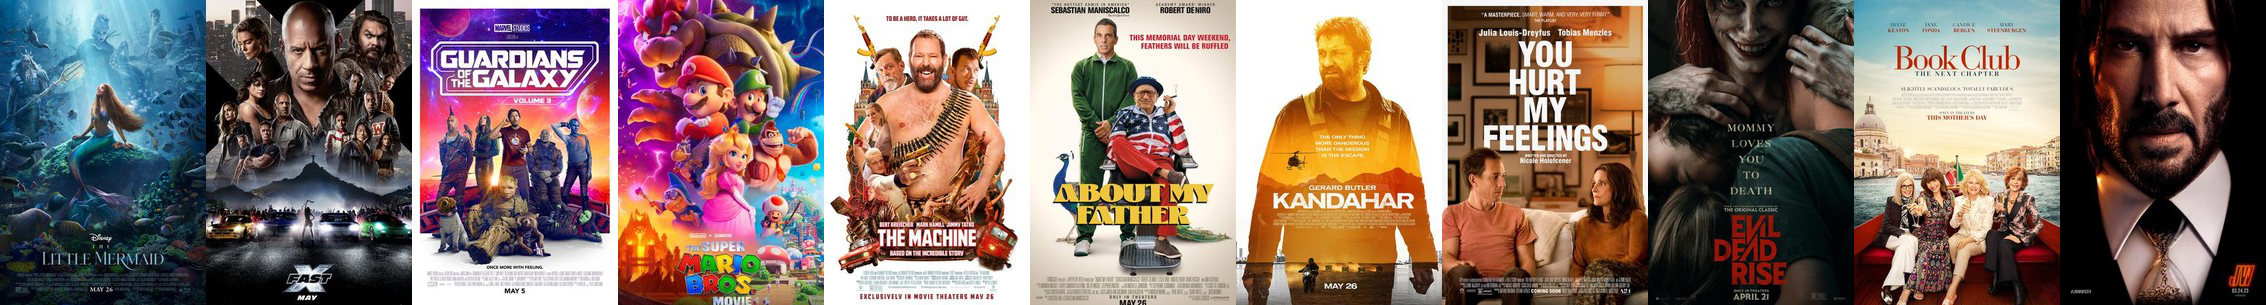

In [8]:
# Top Movie Images
y_coord = 0
first_image = image_df.loc[0,'img_url']
response = requests.get(first_image)
img = Image.open(BytesIO(response.content))
for index, row in image_df.iterrows():
    if index > 10:
        break
    if index == 0:
        mergedImage = img
        continue 
    if row['img_url'] == '':
        continue
    response = requests.get(row['img_url'])
    img = Image.open(BytesIO(response.content))
    image2_size = img.size
    prev_image = mergedImage
    mergedImage = Image.new('RGB',((1+index)*image2_size[0], image2_size[1]), (250,250,250))
    mergedImage.paste(prev_image,(0,y_coord))
    mergedImage.paste(img,((index)*image2_size[0],y_coord))

mergedImage

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Move Poster (Merged By % Revenue)</center></h1>

In [9]:
mergedImage = np.array([])
for index, row in image_df.iterrows():
    if index > 12:
        break
    response = requests.get(row['img_url'])
    img = Image.open(BytesIO(response.content))
    if index == 0:
        mergedImage = np.array(img)
        continue
    mergedImage = cv2.addWeighted(mergedImage, 1, np.array(img), row['rev_norm'], 0)        
img = Image.fromarray(mergedImage)

img.save('merged.png')

<div align='center'>
<img src="merged.png" 
     align="center" 
     width="350" />
    </div>

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Top 5 Movies</center></h1>

In [10]:
top_5_df = weekend_df.loc[:5,['current_rank', 'title', 'weekend_gross']]
top_5_df.weekend_gross = top_5_df.weekend_gross.astype(int)
#Plot top 5 movies
fig = px.bar(top_5_df, x="title", y="weekend_gross", title="Weekend Top 5",
                labels={
                     "weekend_gross": "Weeekend Totals (USD)",
                     "title": ""}, text_auto='.2s', template = "plotly_dark")
fig.update_layout(title_text='<b>Weekend Top 5</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=16  # Set the font size here
    )
)
fig.update_traces(marker_color='green')
fig.show()

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Weekend Revenue Wordcloud</center></h1>

> Titles of top movies sized by proportion of revenue at the box office

(-0.5, 399.5, 199.5, -0.5)

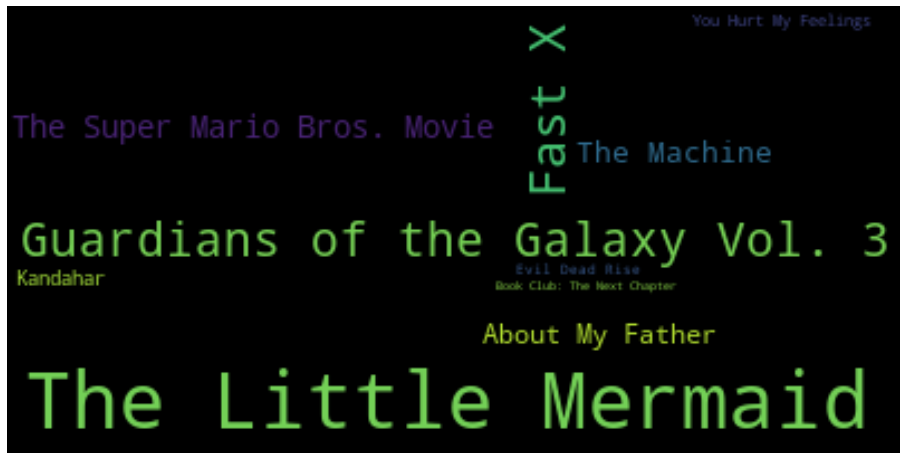

In [11]:
cloud_data = weekend_df.loc[weekend_df.cumulative_gross != '-']
title_dict = dict(zip(cloud_data.title, cloud_data.weekend_gross.astype(float)))
wc = WordCloud(width=400, height=200, min_font_size=5,
                   max_font_size=500, font_step=5)
wc.generate_from_frequencies(title_dict)

plt.figure(figsize=[16,9])
# plot the wordcloud
plt.imshow(wc, interpolation="bilinear")
# remove plot axes
plt.axis("off")

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Changes in Overall Rank</center></h1>

> These movies had larger than expected performance this last weekend

In [12]:
previous_ranked = weekend_df.loc[weekend_df.previous_rank != '-'].copy()
previous_ranked['previous_rank'] = previous_ranked.previous_rank.astype(int)
previous_ranked['current_rank'] = previous_ranked.current_rank.astype(int)
previous_ranked['rank_diff'] = previous_ranked.previous_rank - previous_ranked.current_rank
#sort by rank diff
prev_rank = previous_ranked.sort_values(by=['rank_diff'], ascending=False)

In [13]:
fig = px.bar(prev_rank.head(8),x="title", y="rank_diff", template = "plotly_dark",
                labels={
                     "rank_diff": "Change in Rank",
                     "title": ""
                 }, text_auto='.2s')
fig.update_layout(title_text='<b>Positive Rank Changes</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.update_traces(marker_color='#088F8F')
fig.show()

In [14]:
prev_rank = previous_ranked.sort_values(by=['rank_diff'])
fig = px.bar(prev_rank.head(8),x="title", y="rank_diff", template = "plotly_dark",
                labels={
                     "rank_diff": "Change in Rank",
                     "title": ""
                 }, text_auto='.2s')
fig.update_layout(title_text='<b>Negative Rank Changes</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_xaxes(tickangle=30)
fig.update_traces(marker_color='crimson')
fig.show()

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Changes in Revenue</center></h1>

In [15]:
weekend_jump = weekend_df.loc[weekend_df.weekend_chg != '-'].copy()
weekend_jump['weekend_chg'] = weekend_jump.weekend_chg.astype(float)
#sort by rank diff
weekend_jump = weekend_jump.sort_values(by=['weekend_chg'], ascending=False)

In [16]:
fig = px.bar(weekend_jump.head(8),x="title", y="weekend_chg", template = "plotly_dark",
                         labels={
                     "weekend_chg" : "% Change in Revenue",
                     "title": ""},
text_auto='.2s')
fig.update_layout(title_text='<b>Weekend Revenue Increases</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.update_traces(marker_color='#088F8F')
fig.show()

In [17]:
weekend_jump = weekend_df.loc[weekend_df.weekend_chg != '-'].copy()
weekend_jump['weekend_chg'] = weekend_jump.weekend_chg.astype(float)
#sort by rank diff
weekend_jump = weekend_jump.sort_values(by=['weekend_chg'])

In [18]:
fig = px.bar(weekend_jump.head(8),x="title", y="weekend_chg", template = "plotly_dark",
            labels={
                     "weekend_chg": "% Change in Revenue",
                     "title": ""
                 }, text_auto='.3s')
fig.update_layout(title_text='<b>Weekend Revenue Decreases</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.update_traces(marker_color='crimson')
fig.show()

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Changes In Theatrical Distribution</center></h1>

In [19]:
theater_change = weekend_df.loc[weekend_df.theater_chg != '-'].copy()
theater_change['theater_chg'] = theater_change.theater_chg.astype(int)
#sort by rank diff
theater_change = theater_change.sort_values(by=['theater_chg'], ascending=False).reset_index()

In [20]:
fig = px.bar(theater_change.head(8),x="title", y="theater_chg", template = "plotly_dark",
            labels={
                     "theater_chg": "Change in Theater Count",
                     "title": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='#088F8F')
fig.update_layout(title_text='<b>Increase In # Of Theaters</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.show()

In [21]:
theater_change = weekend_df.loc[weekend_df.theater_chg != '-'].copy()
theater_change['theater_chg'] = theater_change.theater_chg.astype(int)
#sort by rank diff
theater_change = theater_change.sort_values(by=['theater_chg']).reset_index()
theater_change = theater_change.sort_values(by=['theater_chg']).reset_index()

In [22]:
fig = px.bar(theater_change.head(8),x="title", y="theater_chg", title="Drop in # of Theaters", template = "plotly_dark",
            labels={
                     "theater_chg": "Change in Theater Count",
                     "title": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='crimson')
fig.update_layout(title_text='<b>Drop in # of Theaters</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.show()

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Breakdown By Studio</center></h1>

In [23]:
#aggregate weekend amount by studio
studio_df = weekend_df.loc[weekend_df.distributor != '-'].copy()
studio_df['weekend_gross'] = studio_df.weekend_gross.astype(int)
studio_df = studio_df.groupby('distributor').weekend_gross.agg('sum').to_frame()
studio_df['distributor'] = studio_df.index
studio_df = studio_df.sort_values(by=['weekend_gross'], ascending=False)

In [24]:
fig = px.bar(studio_df.head(10), x="distributor", y="weekend_gross", title="Top Distributors", template = "plotly_dark",
                labels={
                     "weekend_gross": "Weeekend Totals (USD)",
                     "distributor": ""
                 }, text_auto='.2s')
fig.update_traces(marker_color='cyan')
fig.update_layout(title_text='<b>Top Distributors</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.show()

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Longest Running Releases - Weeks In Theater</center></h1>

In [25]:
#Movie with weeks = maximum
weekend_df_weeks = weekend_df[weekend_df.weeks != "-"].copy()
weekend_df_weeks['weeks'] = weekend_df_weeks.weeks.astype(int)
weeks_df = weekend_df_weeks.sort_values(by=['weeks'], ascending=False)
fig = px.bar(weeks_df.head(10),x="title", y="weeks", title="Weeks in Theaters", template = "plotly_dark",
                labels={
                     "weeks": "Weeks in Theater",
                     "title": ""
                 }, text_auto='.2s')
fig.update_layout(title_text='<b>Weeks in Theaters</b>', titlefont = dict(
         family = 'Arial, sans-serif',
         size = 30
      ), title_x=0.5)
fig.update_layout(
    font=dict(
        family="Arial, sans-serif",
        size=14
    )
)
fig.update_xaxes(tickangle=30)
fig.update_traces(marker_color='blue')
fig.show()


<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Sources</center></h1>

[Box Office Mojo](https://www.boxofficemojo.com/)

[Rotten Tomatoes](https://www.rottentomatoes.com/)

<h1 style='background:#f3ce13;border:0; color:black;
    box-shadow: 10px 10px 5px 0px rgba(0,0,0,0.75);
    transform: rotateX(10deg);
    '><center style='color: black;'>Thank You</center></h1>
    
 > **Don't forget to Upvote! Thank you so much for supporting my work**